In [1]:
import keras
from keras import layers, models, backend
import numpy as np

In [2]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

In [3]:
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flatten = backend.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = backend.random_normal(shape=(backend.shape(z_mean)[0], latent_dim), 
                                    mean=0., stddev=1.)
    return z_mean + backend.exp(z_log_var) * epsilon

In [5]:
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [7]:
decoder_input = layers.Input(backend.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flatten[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flatten[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = models.Model(decoder_input, x)

In [8]:
z_decoded = decoder(z)

In [9]:
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = backend.flatten(x)
        z_decoded = backend.flatten(z_decoded)
        
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * backend.mean(1 + z_log_var - backend.square(z_mean) 
                                       - backend.exp(z_log_var), axis=-1)
        
        return backend.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [10]:
y = CustomVariationalLayer()([input_img, z_decoded])

In [12]:
vae = models.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [13]:
from keras.datasets import mnist

In [14]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

11493376/11490434 [==============================] - 27s 2us/step


In [15]:
vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, 
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 513s 9ms/step - loss: 0.2807 - val_loss: 0.1959
Epoch 2/10
60000/60000 [==============================] - 518s 9ms/step - loss: 0.1945 - val_loss: 0.1902
Epoch 3/10
60000/60000 [==============================] - 525s 9ms/step - loss: 0.1899 - val_loss: 0.1896
Epoch 4/10
60000/60000 [==============================] - 536s 9ms/step - loss: 0.1873 - val_loss: 0.1862
Epoch 5/10
  336/60000 [..............................] - ETA: 8:06 - loss: 0.1845

KeyboardInterrupt: 

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [17]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size : (i + 1) * digit_size, 
               j * digit_size : (j + 1) * digit_size] = digit

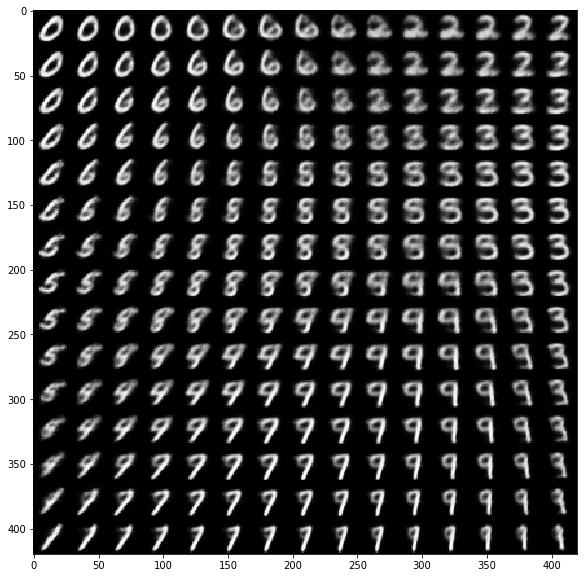

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()